In [2]:
# ---------------------- XGBOOST CLASSIFIER (Simple Explanation) ----------------------
# XGBoost is a powerful gradient boosting algorithm.
# It builds many shallow decision trees one after another.
# Each new tree focuses on correcting the errors of the previous ones, making it
# very strong for tabular data and classification problems.

# ---------------------- 1. IMPORT REQUIRED LIBRARIES ----------------------

import pandas as pd                                  # For loading and handling tabular data
import numpy as np                                   # For numerical operations
import matplotlib.pyplot as plt                      # For plotting graphs
import seaborn as sns                                # For nicer visualizations

from sklearn.model_selection import train_test_split # Split data into train/test sets
from sklearn.preprocessing import StandardScaler     # Scale numeric features (if needed)
from sklearn.metrics import (
    classification_report,                           # Precision, recall, f1-score
    confusion_matrix,                                # Correct vs incorrect predictions
    accuracy_score                                   # Overall accuracy
)

from xgboost import XGBClassifier                    # XGBoost classification model


In [3]:
# ---------------------- 2. LOAD THE DATASET ----------------------
# Replacing local Windows path with a Kaggle dataset link:
# Kaggle Dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

df = pd.read_csv("creditcard.csv")   # Load the Credit Card Fraud dataset
df.head()                            # Show first 5 rows


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# ---------------------- 3. CHECK BASIC DATA INFORMATION ----------------------
# shape        → number of rows and columns
# isnull().sum → total missing values per column
# info()       → column types + memory usage

print("Shape:", df.shape)

print("\nMissing values:\n", df.isnull().sum())

df.info()


Shape: (284807, 31)

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10  

Class
0    284315
1       492
Name: count, dtype: int64


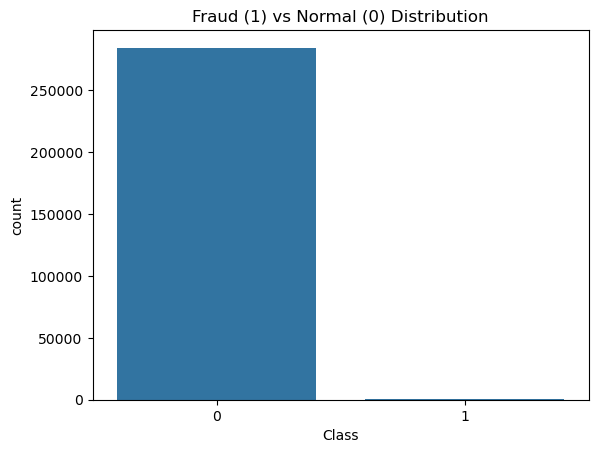

In [5]:
# ---------------------- 4. CHECK CLASS DISTRIBUTION ----------------------
# Class = 0 → Normal transaction
# Class = 1 → Fraud transaction
# The dataset is highly imbalanced (very few fraud cases).

print(df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Fraud (1) vs Normal (0) Distribution")
plt.show()


In [6]:
# ---------------------- 5. SCALE 'Time' AND 'Amount' FEATURES ----------------------
# Most columns in this dataset are already PCA-transformed (V1, V2, ... V28).
# But 'Time' and 'Amount' are raw numeric values → we scale them for better performance.

scaler = StandardScaler()

df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))      # Scale Time
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))  # Scale Amount

df = df.drop(['Time', 'Amount'], axis=1)   # Remove original unscaled columns


In [7]:
# ---------------------- 6. SPLIT FEATURES AND TARGET ----------------------
# X = all features
# y = target label (Class: 0 = normal, 1 = fraud)
# stratify=y keeps the same fraud imbalance in train and test sets.

X = df.drop('Class', axis=1)   # Features
y = df['Class']                # Target label

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((227845, 30), (56962, 30))

In [8]:
# ---------------------- 7. TRAIN XGBOOST CLASSIFIER ----------------------
# Key parameters:
# n_estimators      → number of boosting rounds (trees)
# max_depth         → depth of each tree (controls model complexity)
# learning_rate     → how much each tree contributes (lower = more stable)
# subsample         → % of rows used per tree (prevents overfitting)
# colsample_bytree  → % of features per tree
# scale_pos_weight  → handles severe class imbalance (fraud cases are rare)

model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y) - sum(y)) / sum(y),  # weight fraud cases more strongly
    random_state=42,
)

model.fit(X_train, y_train)    # Train the model


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [9]:
# ---------------------- 8. PREDICT & EVALUATE MODEL ----------------------
# model.predict() → predicts fraud (1) or normal (0)
# accuracy_score  → overall accuracy
# classification_report → precision, recall, f1-score for each class

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9992802219023208

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.86      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [10]:
# ---------------------- 9. FEATURE IMPORTANCE ----------------------
# XGBoost provides importance scores showing which features contributed most.
# Higher importance → more influence in detecting fraud.

importance = model.feature_importances_   # Importance values from the model
features = X.columns                      # Feature names

imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by="Importance", ascending=False)   # Sort from most → least important

imp_df.head(10)   # Show top 10 most important features


,Feature,Importance
13,V14,0.322660
9,V10,0.164850
3,V4,0.078933
19,V20,0.039367
11,V12,0.034582
29,scaled_amount,0.028677
7,V8,0.021196
18,V19,0.020832
25,V26,0.020693
6,V7,0.020269


In [17]:
# ---------------------- 10. INFERENCE ON A NEW TRANSACTION ----------------------
# We pick one example transaction from the test set.
# model.predict() → fraud (1) or normal (0)
# model.predict_proba() → probability the transaction is fraud.

sample = X_test.iloc[724]                     # Select one row from test data
sample_df = pd.DataFrame([sample])            # Convert to DataFrame

prediction_class = model.predict(sample_df)[0]        # Predicted class
prediction_prob = model.predict_proba(sample_df)[0][1]# Probability of fraud (class 1)

print("Predicted Class (0=Normal, 1=Fraud):", prediction_class)
print(f"Fraud Probability: {prediction_prob:.4f}")


Predicted Class (0=Normal, 1=Fraud): 0
Fraud Probability: 0.0002
